In [ ]:
#Integrantes:
# María Tapia
# Mariela Gonzáles
# Jonathan Sánchez
# Master: Ciencias de Datos e Inteligencia Artificial

In [ ]:
#Importar Liberias necesarias para utilizar los modelos de IA
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
import tensorflow as tf
import tensorflow_hub as hub
from collections import Counter
from wordcloud import WordCloud

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Carga de datos
train_data = pd.read_csv('drive/MyDrive/Colab Notebooks/lab2_ceste/train.csv')
test_data = pd.read_csv('drive/MyDrive/Colab Notebooks/lab2_ceste/test.csv')

In [ ]:
# Imprimir los datos de entrenamiento y test
train_df = train_data
test_df = test_data

print(f"entrenamiento {train_df.shape}")
print(f"test {test_df.shape}")

entrenamiento (7613, 5)
test (3263, 4)


In [ ]:
#Descargar conjunto de tweets desde la libreria NLTK
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Normalizar las palabras
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
#Limpiar las palabras de acentos, url y reducir a su forma base
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Eliminar caracteres no alfabéticos
    text = text.lower()  # Convertir a minúsculas
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Eliminar stop words y lematizar
    return ' '.join(tokens)

train_df['text_cleaned'] = train_df['text'].apply(preprocess_text)
test_df['text_cleaned'] = test_df['text'].apply(preprocess_text)

In [ ]:
# Funcion para crear los archivos de resultados del modelo
def crear_archivo(pd,modelo, y_pred_test):
    submission_df = pd.DataFrame({'id': test_df['id'], 'target': y_pred_test})
    submission_df.to_csv('submission_'+modelo+'_.csv', index=False)
    print(f"El archivo de entrega del modelo {modelo} fué creado")

In [ ]:
#Funcion para graficar los resultados de cada modelo
def graficar_resultados(train_accuracy, val_accuracy, y_val, y_pred_val, model_name=""):

    # Matriz de confusión
    cm = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
    plt.title(f'Confusion Matrix (Validation Set, {model_name})') # Título dinámico
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Curva Precision-Recall
    # Solo para modelos que pueden predecir probabilidades (NB, LR, etc.)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_val)[:, 1] # Probabilidades de la clase positiva
        precision, recall, _ = precision_recall_curve(y_val, y_scores)
        average_precision = average_precision_score(y_val, y_scores)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', alpha=0.8, lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve (Validation Set, {model_name})')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.show()

        # Histograma de la distribución de las probabilidades predichas
        plt.figure(figsize=(10, 6))
        sns.histplot(y_scores[y_val == 0], color='red', label='Not Disaster (True Negative)', kde=True, stat='density', alpha=0.6)
        sns.histplot(y_scores[y_val == 1], color='green', label='Disaster (True Positive)', kde=True, stat='density', alpha=0.6)
        plt.title(f'Distribution of Predicted Probabilities on Validation Set ({model_name})')
        plt.xlabel('Predicted Probability of Disaster')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Identificar falsos positivos y falsos negativos
        false_positives_local_indices = np.where((y_pred_val == 1) & (y_val == 0))[0]
        false_negatives_local_indices = np.where((y_pred_val == 0) & (y_val == 1))[0]

        print(f"\n--- Ejemplos de Falsos Positivos ({model_name}) ---")
        for i_local in false_positives_local_indices[:5]:
            original_df_index = val_indices[i_local]
            print(f"Tweet Original: {train_df['text'].iloc[original_df_index]}")
            print(f"Tweet Limpio: {train_df['text_cleaned'].iloc[original_df_index]}")
            print("-" * 50)

        print(f"\n--- Ejemplos de Falsos Negativos ({model_name}) ---")
        for i_local in false_negatives_local_indices[:5]:
            original_df_index = val_indices[i_local]
            print(f"Tweet Original: {train_df['text'].iloc[original_df_index]}")
            print(f"Tweet Limpio: {train_df['text_cleaned'].iloc[original_df_index]}")
            print("-" * 50)

    # Matriz de Confusión
    cm_normalized = confusion_matrix(y_val, y_pred_val, normalize='true')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['No Desastre', 'Desastre'], yticklabels=['No Desastre', 'Desastre'])
    plt.title(f'Matriz de Confusión Normalizada (Conjunto de Validación, {model_name})')
    plt.xlabel('Etiquetas Predichas')
    plt.ylabel('Etiquetas Verdaderas')
    plt.show()

def graficar_datos_entrenamiento_validacion(train_accuracy, ptl,val_accuracy, model_name=""):
    plt.figure(figsize=(8, 6))
    plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_accuracy, val_accuracy], color=['blue', 'green'])
    plt.ylim(0, 1)
    plt.title(f'Training and Validation Accuracy ({model_name})') # Título dinámico
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
# Función para comparar modelos
def comparar_modelos(model_metrics):
    models = list(model_metrics.keys())
    accuracies = [model_metrics[model]['accuracy'] for model in models]
    f1_scores = [model_metrics[model]['f1_score'] for model in models]

    # Gráfico de barras para la precisión de validación
    plt.figure(figsize=(12, 7))
    sns.barplot(x=models, y=accuracies, palette='viridis')
    plt.ylim(0, 1)
    plt.title('Comparación de Precisión de Validación (Accuracy) entre Modelos')
    plt.xlabel('Modelo')
    plt.ylabel('Precisión de Validación')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Gráfico de barras para el F1-Score
    plt.figure(figsize=(12, 7))
    sns.barplot(x=models, y=f1_scores, palette='magma')
    plt.ylim(0, 1)
    plt.title('Comparación de F1-Score entre Modelos')
    plt.xlabel('Modelo')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# Función para comparar modelos
def comparar_modelos(model_metrics):
    models = list(model_metrics.keys())
    accuracies = [model_metrics[model]['accuracy'] for model in models]
    f1_scores = [model_metrics[model]['f1_score'] for model in models]

    # Gráfico de barras para la precisión de validación
    plt.figure(figsize=(12, 7))
    sns.barplot(x=models, y=accuracies, palette='viridis')
    plt.ylim(0, 1)
    plt.title('Comparación de Precisión de Validación (Accuracy) entre Modelos')
    plt.xlabel('Modelo')
    plt.ylabel('Precisión de Validación')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Gráfico de barras para el F1-Score
    plt.figure(figsize=(12, 7))
    sns.barplot(x=models, y=f1_scores, palette='magma')
    plt.ylim(0, 1)
    plt.title('Comparación de F1-Score entre Modelos')
    plt.xlabel('Modelo')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
#convertir el texto sin procesar en una representación numérica
vectorizer = TfidfVectorizer(
    max_features=1_000_000,
    ngram_range=(1, 4),
    sublinear_tf=True)

In [ ]:
# Objeto diccionario para almacenar las métricas de cada modelo
model_comparison_metrics = {}

In [ ]:


print(train_df.head())
print(test_df.head())

X = vectorizer.fit_transform(train_df['text_cleaned'])
y = train_df['target']
X_test = vectorizer.transform(test_df['text_cleaned'])


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                       text_cleaned  
0       1         deed reason earthquake may allah forgive u  
1       1              forest fire near la ronge sask canada  
2       1  resident asked shelter place notified officer ...  
3       1  people receive wildfire evacuation order calif...  
4       1  got sent photo ruby alaska smoke wildfire pour...  
   id keyword location                                               text  \
0   0     NaN      NaN                 Just happened a terrible car crash   
1   2

In [ ]:
def imprimir_predicciones(y_pred_test):
  for i in range(min(10, len(test_df))):
      tweet_id = test_df['id'].iloc[i]
      tweet_text = test_df['text'].iloc[i]
      prediction = y_pred_test[i]
      if prediction == 1:
          print(f"Tweet ID: {tweet_id}, Prediction: Disaster Tweet, Text: {tweet_text}")
      else:
          print(f"Tweet ID: {tweet_id}, Prediction: Not Disaster Tweet, Text: {tweet_text}")

In [ ]:
def get_top_n_words(text, n=None):
    words = text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)

In [ ]:

# Modelo Naive Bayes Multinomial
print("\n--- Modelo: Naive Bayes Multinomial ---")

original_train_df_indices = np.arange(len(train_df))
X_train, X_val, y_train, y_val, train_indices, val_indices = train_test_split(
    X, y, original_train_df_indices, test_size=0.2, random_state=42
)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
print(classification_report(y_val, y_pred_val))
y_pred_test = model.predict(X_test)


--- Modelo: Naive Bayes Multinomial ---
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       874
           1       0.89      0.57      0.69       649

    accuracy                           0.79      1523
   macro avg       0.82      0.76      0.76      1523
weighted avg       0.81      0.79      0.78      1523



In [ ]:
imprimir_predicciones(y_pred_test)

Tweet ID: 0, Prediction: Disaster Tweet, Text: Just happened a terrible car crash
Tweet ID: 2, Prediction: Disaster Tweet, Text: Heard about #earthquake is different cities, stay safe everyone.
Tweet ID: 3, Prediction: Disaster Tweet, Text: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Tweet ID: 9, Prediction: Disaster Tweet, Text: Apocalypse lighting. #Spokane #wildfires
Tweet ID: 11, Prediction: Disaster Tweet, Text: Typhoon Soudelor kills 28 in China and Taiwan
Tweet ID: 12, Prediction: Disaster Tweet, Text: We're shaking...It's an earthquake
Tweet ID: 21, Prediction: Not Disaster Tweet, Text: They'd probably still show more life than Arsenal did yesterday, eh? EH?
Tweet ID: 22, Prediction: Not Disaster Tweet, Text: Hey! How are you?
Tweet ID: 27, Prediction: Not Disaster Tweet, Text: What a nice hat?
Tweet ID: 29, Prediction: Not Disaster Tweet, Text: Fuck off!


In [ ]:

# Word Cloud y Top Palabras
def imprimir_palabras_mas_frecuentes(disaster_text, not_disaster_text):
      disaster_text = " ".join(train_df[train_df['target'] == 1]['text_cleaned'])
      not_disaster_text = " ".join(train_df[train_df['target'] == 0]['text_cleaned'])

      wordcloud_disaster = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(disaster_text)
      wordcloud_not_disaster = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(not_disaster_text)

      plt.figure(figsize=(15, 7))
      plt.subplot(1, 2, 1)
      plt.imshow(wordcloud_disaster, interpolation='bilinear')
      plt.title('Palabras Más Frecuentes en Tweets de Desastre')
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.imshow(wordcloud_not_disaster, interpolation='bilinear')
      plt.title('Palabras Más Frecuentes en Tweets No de Desastre')
      plt.axis('off')
      plt.tight_layout()
      plt.show()


      top_disaster_words = get_top_n_words(disaster_text, 15)
      top_not_disaster_words = get_top_n_words(not_disaster_text, 15)

      df_disaster_words = pd.DataFrame(top_disaster_words, columns=['Word', 'Count'])
      df_not_disaster_words = pd.DataFrame(top_not_disaster_words, columns=['Word', 'Count'])

      plt.figure(figsize=(15, 6))
      plt.subplot(1, 2, 1)
      sns.barplot(x='Count', y='Word', data=df_disaster_words, palette='Reds_d')
      plt.title('Top 15 Palabras en Tweets de Desastre')
      plt.xlabel('Frecuencia')
      plt.ylabel('Palabra')

      plt.subplot(1, 2, 2)
      sns.barplot(x='Count', y='Word', data=df_not_disaster_words, palette='Greens_d')
      plt.title('Top 15 Palabras en Tweets No de Desastre')
      plt.xlabel('Frecuencia')
      plt.ylabel('Palabra')
      plt.tight_layout()
      plt.show()

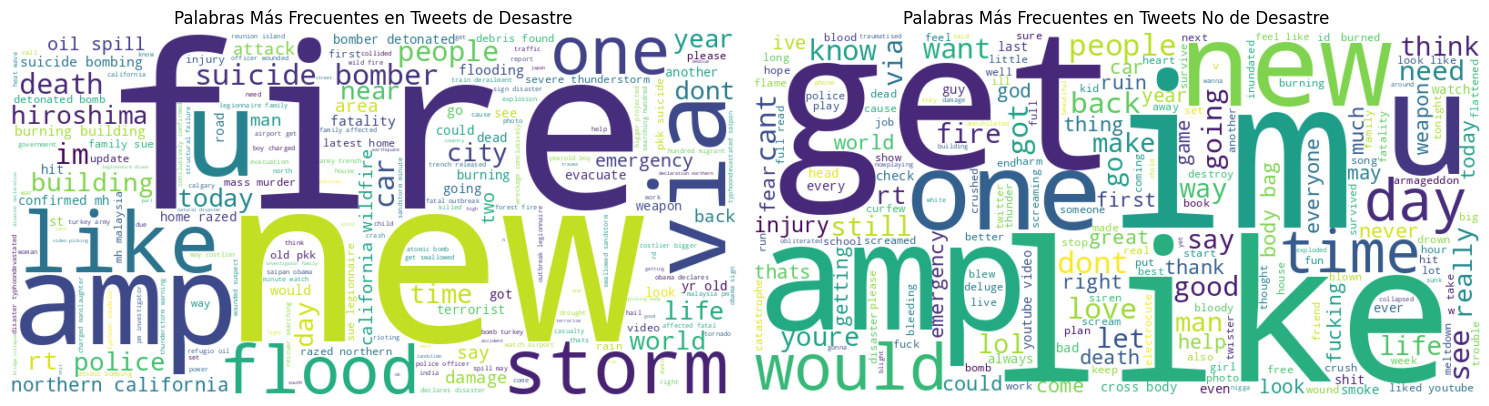

<ipython-input-97-f5ab90e70d58>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_disaster_words, palette='Reds_d')
<ipython-input-97-f5ab90e70d58>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_not_disaster_words, palette='Greens_d')


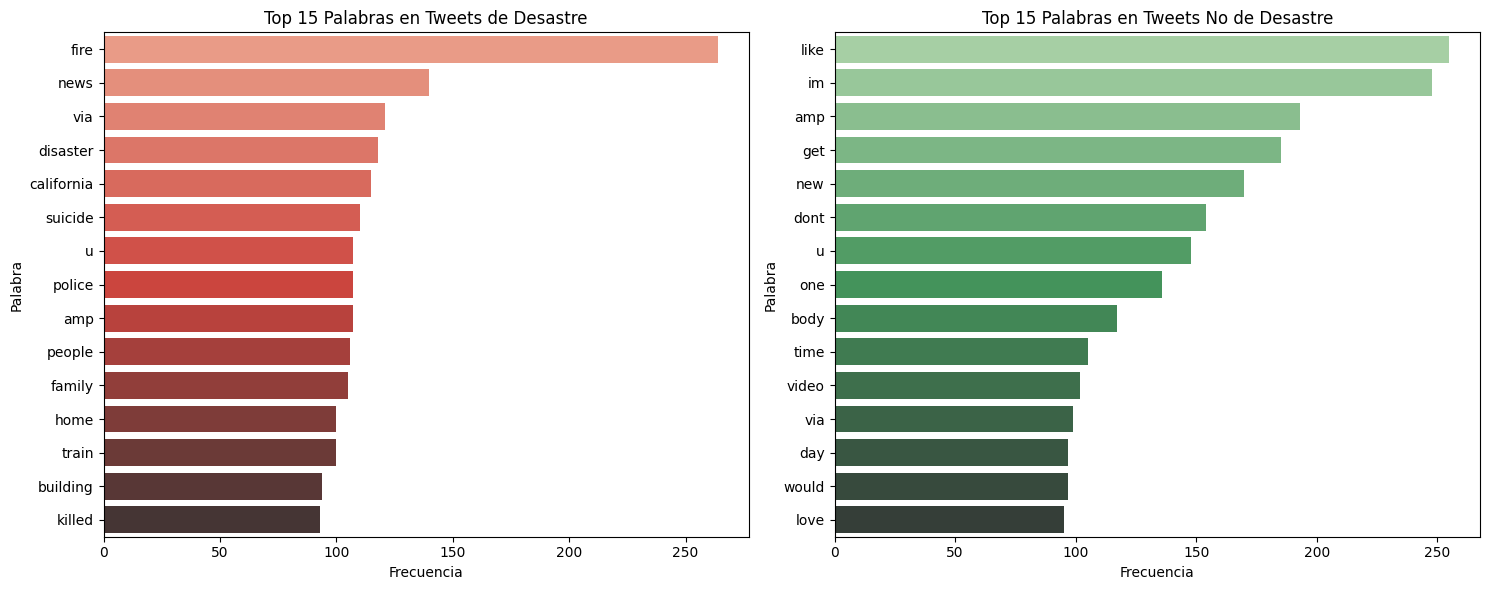

In [ ]:
#Palabras mas frecuentes
imprimir_palabras_mas_frecuentes(disaster_text, not_disaster_text)

Tweet ID: 0, Prediction: Disaster Tweet, Text: Just happened a terrible car crash
Tweet ID: 2, Prediction: Disaster Tweet, Text: Heard about #earthquake is different cities, stay safe everyone.
Tweet ID: 3, Prediction: Disaster Tweet, Text: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Tweet ID: 9, Prediction: Disaster Tweet, Text: Apocalypse lighting. #Spokane #wildfires
Tweet ID: 11, Prediction: Disaster Tweet, Text: Typhoon Soudelor kills 28 in China and Taiwan
Tweet ID: 12, Prediction: Disaster Tweet, Text: We're shaking...It's an earthquake
Tweet ID: 21, Prediction: Not Disaster Tweet, Text: They'd probably still show more life than Arsenal did yesterday, eh? EH?
Tweet ID: 22, Prediction: Not Disaster Tweet, Text: Hey! How are you?
Tweet ID: 27, Prediction: Not Disaster Tweet, Text: What a nice hat?
Tweet ID: 29, Prediction: Not Disaster Tweet, Text: Fuck off!
El archivo de entrega del modelo nayve_bayes fué creado
F1 SCORE: 0.694

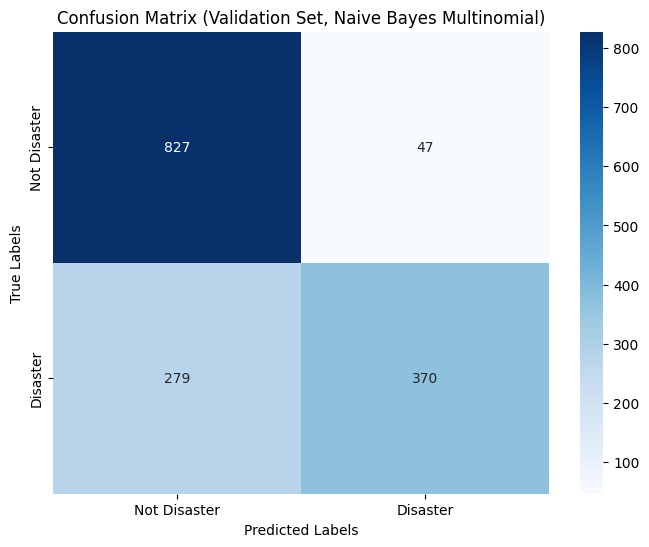

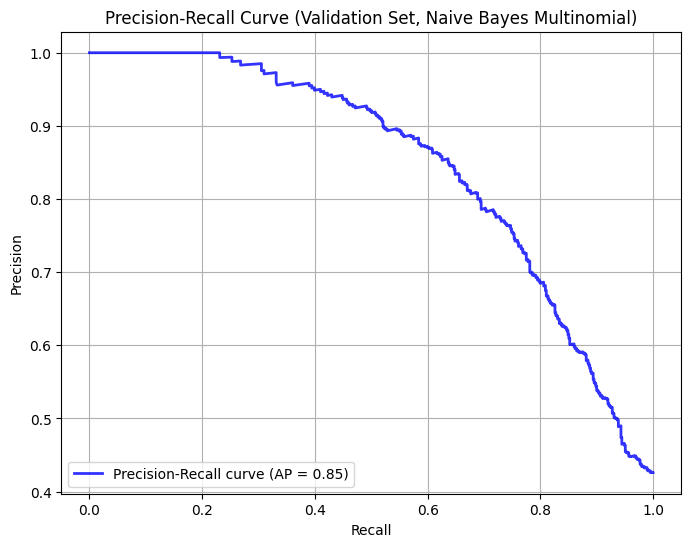

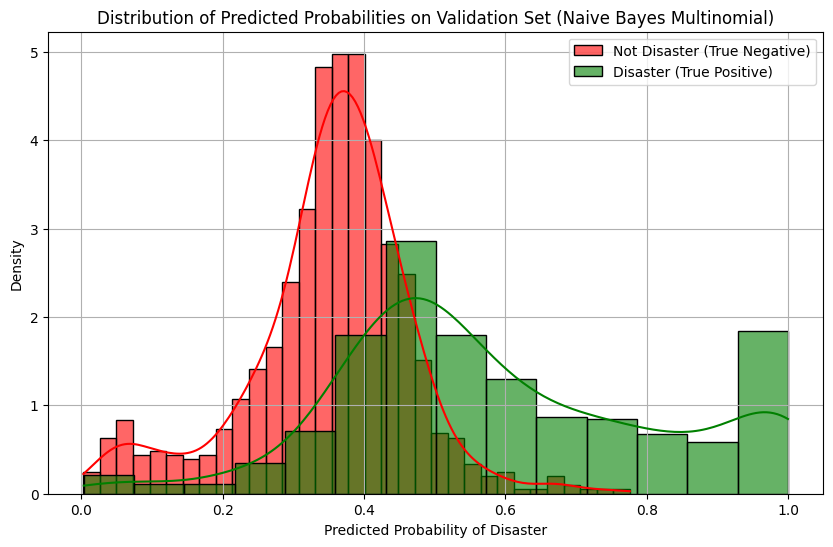


--- Ejemplos de Falsos Positivos (Naive Bayes Multinomial) ---
Tweet Original: Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE
Tweet Limpio: bringing tornado flood bringing climate change god america plaguing farrakhan quote
--------------------------------------------------
Tweet Original: she's a suicide bomb
Tweet Limpio: shes suicide bomb
--------------------------------------------------
Tweet Original: When your heart is bigger than the obstacles  in front of you #euro #dontexpectnothing #july #fire @euro
Tweet Limpio: heart bigger obstacle front euro dontexpectnothing july fire euro
--------------------------------------------------
Tweet Original: Bayelsa poll: Tension in Bayelsa as Patience Jonathan plans to hijack APC PDP: Plans by former First Lady and... http://t.co/3eJL9lZlCH
Tweet Limpio: bayelsa poll tension bayelsa patience jonathan plan hijack apc pdp plan former first lady
-----

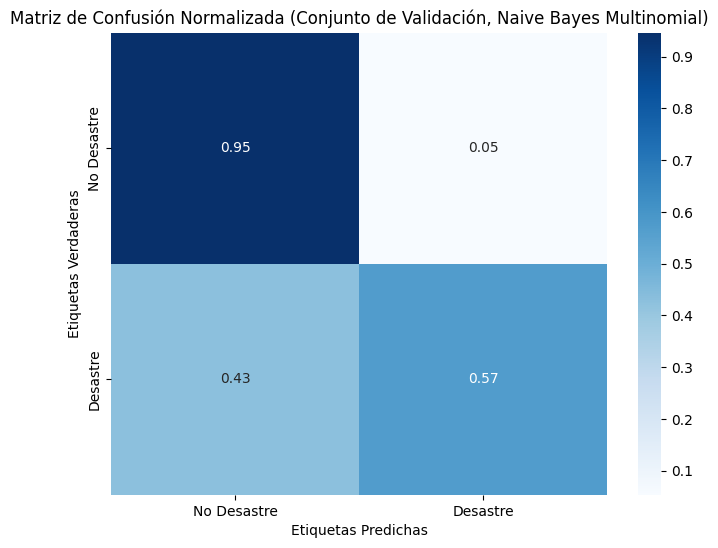

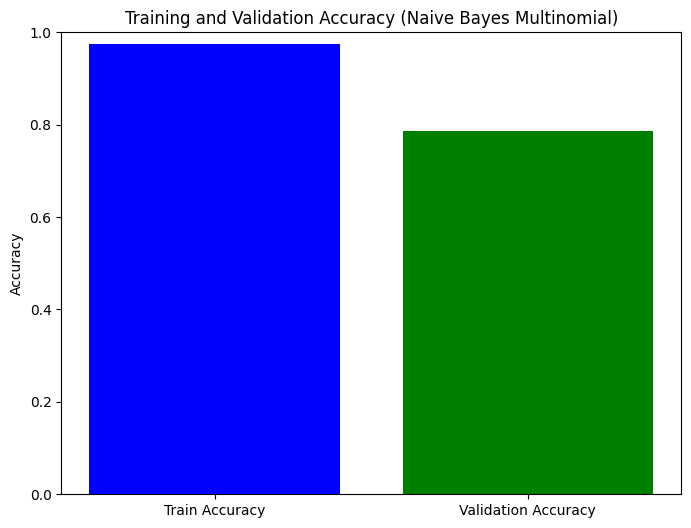

        Prediction                                               Text
0         Disaster                 Just happened a terrible car crash
1         Disaster  Heard about #earthquake is different cities, s...
2         Disaster  there is a forest fire at spot pond, geese are...
3         Disaster           Apocalypse lighting. #Spokane #wildfires
4         Disaster      Typhoon Soudelor kills 28 in China and Taiwan
...            ...                                                ...
3258      Disaster  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259  Not Disaster  Storm in RI worse than last hurricane. My city...
3260      Disaster  Green Line derailment in Chicago http://t.co/U...
3261      Disaster  MEG issues Hazardous Weather Outlook (HWO) htt...
3262      Disaster  #CityofCalgary has activated its Municipal Eme...

[3263 rows x 2 columns]


In [ ]:
imprimir_predicciones(y_pred_test)

crear_archivo(pd,"nayve_bayes", y_pred_test)

y_pred_train = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)
print(f'F1 SCORE: {f1}')



graficar_resultados(train_accuracy, val_accuracy, y_val, y_pred_val, "Naive Bayes Multinomial")
graficar_datos_entrenamiento_validacion(train_accuracy, plt,val_accuracy, "Naive Bayes Multinomial")

model_comparison_metrics['Naive Bayes'] = {'accuracy': val_accuracy, 'f1_score': f1}

results_df = pd.DataFrame({
    'Prediction': ['Disaster' if pred == 1 else 'Not Disaster' for pred in y_pred_test],
    'Text': test_df['text']
})
print(results_df)



--- Modelo: Random Forest ---
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       874
           1       0.87      0.59      0.70       649

    accuracy                           0.79      1523
   macro avg       0.81      0.76      0.77      1523
weighted avg       0.80      0.79      0.78      1523

Tweet ID: 0, Prediction: Disaster Tweet, Text: Just happened a terrible car crash
Tweet ID: 2, Prediction: Disaster Tweet, Text: Heard about #earthquake is different cities, stay safe everyone.
Tweet ID: 3, Prediction: Disaster Tweet, Text: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Tweet ID: 9, Prediction: Disaster Tweet, Text: Apocalypse lighting. #Spokane #wildfires
Tweet ID: 11, Prediction: Disaster Tweet, Text: Typhoon Soudelor kills 28 in China and Taiwan
Tweet ID: 12, Prediction: Disaster Tweet, Text: We're shaking...It's an earthquake
Tweet ID: 21, Prediction: Not Disaster 

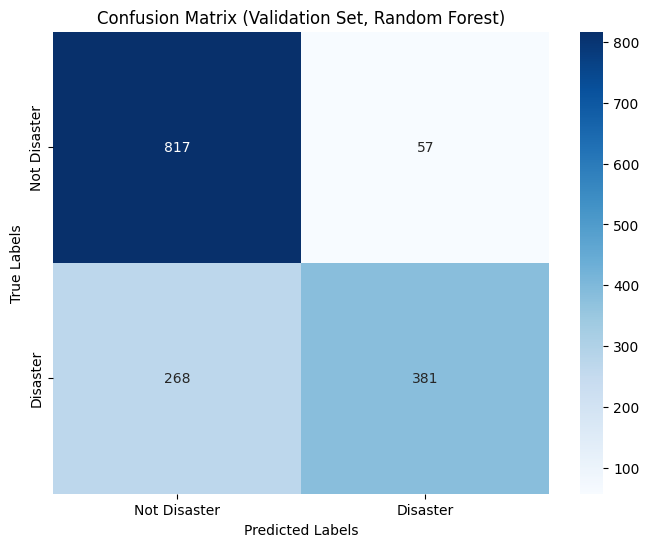

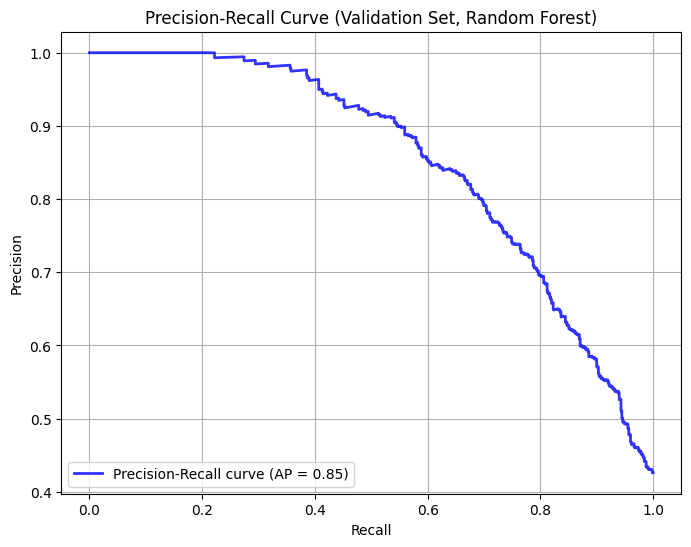

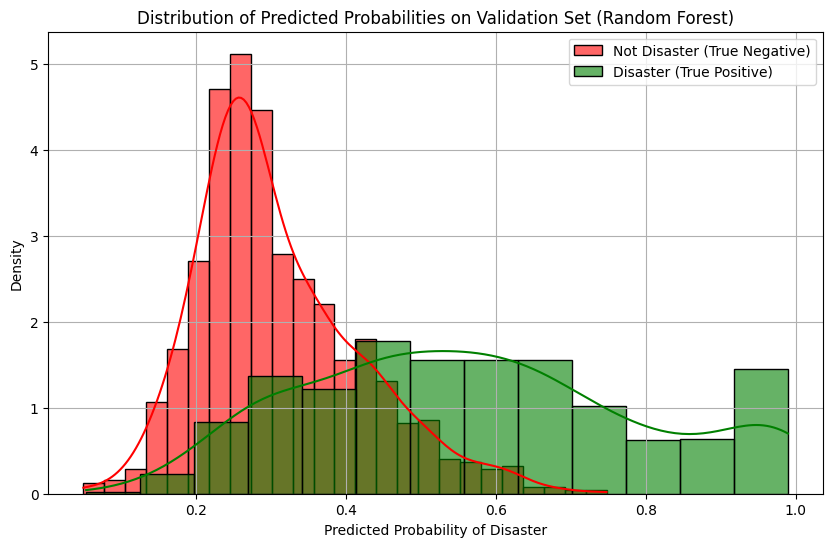


--- Ejemplos de Falsos Positivos (Random Forest) ---
Tweet Original: Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE
Tweet Limpio: bringing tornado flood bringing climate change god america plaguing farrakhan quote
--------------------------------------------------
Tweet Original: she's a suicide bomb
Tweet Limpio: shes suicide bomb
--------------------------------------------------
Tweet Original: When your heart is bigger than the obstacles  in front of you #euro #dontexpectnothing #july #fire @euro
Tweet Limpio: heart bigger obstacle front euro dontexpectnothing july fire euro
--------------------------------------------------
Tweet Original: Dust devil maintenance fee - buy up la rotary storm guard: UVoPWZ
Tweet Limpio: dust devil maintenance fee buy la rotary storm guard uvopwz
--------------------------------------------------
Tweet Original: Over half of poll respondents worry nuclear disa

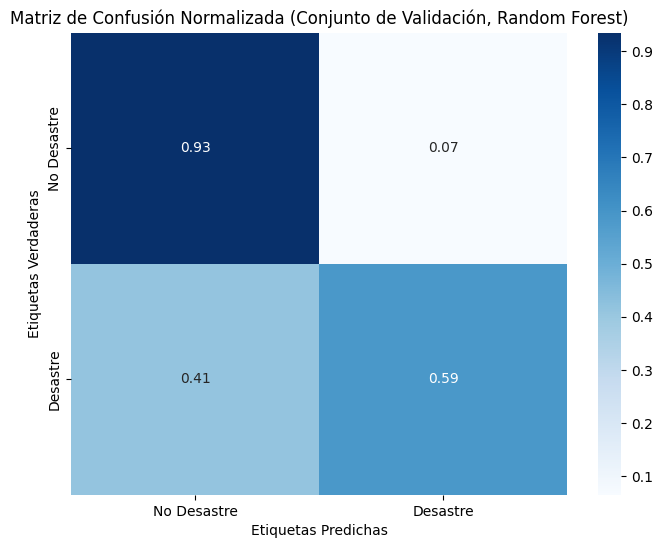

        Prediction                                               Text
0         Disaster                 Just happened a terrible car crash
1         Disaster  Heard about #earthquake is different cities, s...
2         Disaster  there is a forest fire at spot pond, geese are...
3         Disaster           Apocalypse lighting. #Spokane #wildfires
4         Disaster      Typhoon Soudelor kills 28 in China and Taiwan
...            ...                                                ...
3258      Disaster  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259  Not Disaster  Storm in RI worse than last hurricane. My city...
3260      Disaster  Green Line derailment in Chicago http://t.co/U...
3261      Disaster  MEG issues Hazardous Weather Outlook (HWO) htt...
3262      Disaster  #CityofCalgary has activated its Municipal Eme...

[3263 rows x 2 columns]


In [ ]:

# Utilizando Random Forest
print("\n--- Modelo: Random Forest ---")
X = vectorizer.fit_transform(train_df['text_cleaned'])
y = train_df['target']
X_test = vectorizer.transform(test_df['text_cleaned'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=None, min_samples_leaf=3, n_jobs = -1)
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
print(classification_report(y_val, y_pred_val))

y_pred_test = model.predict(X_test)

imprimir_predicciones(y_pred_test)

crear_archivo(pd,"random_forest", y_pred_test)

train_accuracy = accuracy_score(y_train, model.predict(X_train))
val_accuracy = accuracy_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)
print(f'F1 SCORE: {f1}')

graficar_resultados(train_accuracy, val_accuracy, y_val, y_pred_val, "Random Forest")

model_comparison_metrics['Random Forest'] = {'accuracy': val_accuracy, 'f1_score': f1}

results_df = pd.DataFrame({
    'Prediction': ['Disaster' if pred == 1 else 'Not Disaster' for pred in y_pred_test],
    'Text': test_df['text']
})
print(results_df)



--- Modelo: Naive Bayes (GridSearchCV) ---
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       874
           1       0.71      0.78      0.74       649

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.77      0.77      1523

Tweet ID: 0, Prediction: Disaster Tweet, Text: Just happened a terrible car crash
Tweet ID: 2, Prediction: Disaster Tweet, Text: Heard about #earthquake is different cities, stay safe everyone.
Tweet ID: 3, Prediction: Disaster Tweet, Text: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Tweet ID: 9, Prediction: Disaster Tweet, Text: Apocalypse lighting. #Spokane #wildfires
Tweet ID: 11, Prediction: Disaster Tweet, Text: Typhoon Soudelor kills 28 in China and Taiwan
Tweet ID: 12, Prediction: Disaster Tweet, Text: We're shaking...It's an earthquake
Tweet ID: 21, Prediction: 

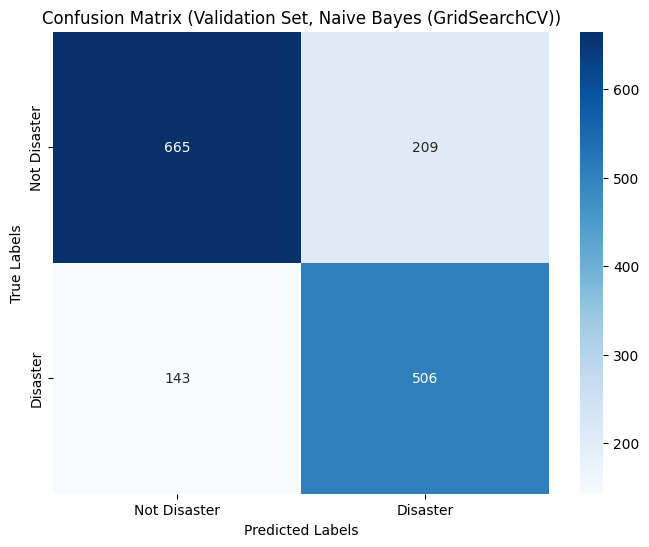

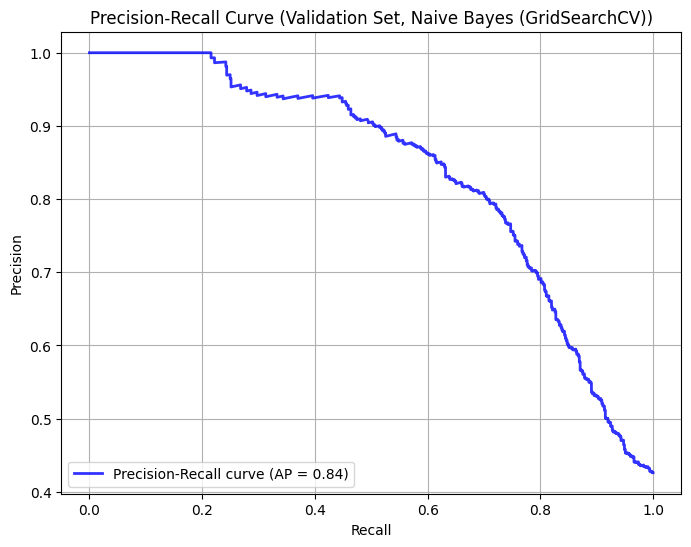

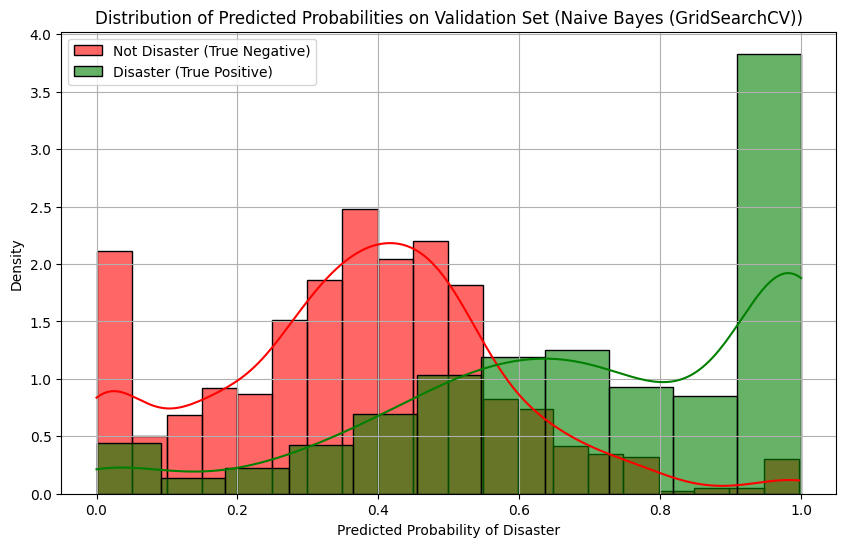


--- Ejemplos de Falsos Positivos (Naive Bayes (GridSearchCV)) ---
Tweet Original: in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3
Tweet Limpio: response trauma child addict develop defensive self one decrease vulnerability
--------------------------------------------------
Tweet Original: @Zak_Bagans pets r like part of the family. I love animals.??? The last 2 pets I had I rescued! Breaks my heart when animals are mistreated????
Tweet Limpio: zakbagans pet r like part family love animal last pet rescued break heart animal mistreated
--------------------------------------------------
Tweet Original: ON THE USE OF PERFORATED METAL SHEAR PANEL SFOR SEISMIC-RESISTANT APPLICATIONS http://t.co/cX5OjH2Dr4
Tweet Limpio: use perforated metal shear panel sfor seismicresistant application
--------------------------------------------------
Tweet Original: Who is bringing the tornadoes and floods. Who is bringing the climate change. God is

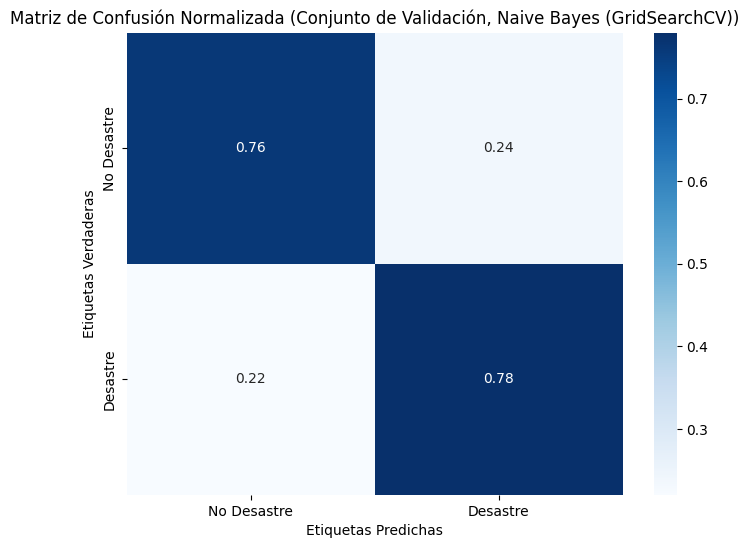

     Prediction                                               Text
0      Disaster                 Just happened a terrible car crash
1      Disaster  Heard about #earthquake is different cities, s...
2      Disaster  there is a forest fire at spot pond, geese are...
3      Disaster           Apocalypse lighting. #Spokane #wildfires
4      Disaster      Typhoon Soudelor kills 28 in China and Taiwan
...         ...                                                ...
3258   Disaster  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259   Disaster  Storm in RI worse than last hurricane. My city...
3260   Disaster  Green Line derailment in Chicago http://t.co/U...
3261   Disaster  MEG issues Hazardous Weather Outlook (HWO) htt...
3262   Disaster  #CityofCalgary has activated its Municipal Eme...

[3263 rows x 2 columns]


In [ ]:

# Utilizando otras tecnicas (GridSearchCV con Naive Bayes)
print("\n--- Modelo: Naive Bayes (GridSearchCV) ---")
X = vectorizer.fit_transform(train_df['text_cleaned'])
y = train_df['target']
X_test = vectorizer.transform(test_df['text_cleaned'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=3)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
model = best_model # Asignar el mejor modelo a 'model' para graficar_resultados

y_pred_val = best_model.predict(X_val)
print(classification_report(y_val, y_pred_val))

y_pred_test = best_model.predict(X_test)

imprimir_predicciones(y_pred_test)

crear_archivo(pd,"naive_bayes_gridsearch", y_pred_test)

y_pred_train = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)
print(f'F1 SCORE: {f1}')

graficar_resultados(train_accuracy, val_accuracy, y_val, y_pred_val, "Naive Bayes (GridSearchCV)")

model_comparison_metrics['Naive Bayes (GridSearchCV)'] = {'accuracy': val_accuracy, 'f1_score': f1}

results_df = pd.DataFrame({
    'Prediction': ['Disaster' if pred == 1 else 'Not Disaster' for pred in y_pred_test],
    'Text': test_df['text']
})
print(results_df)



--- Modelo: Logistic Regression ---
              precision    recall  f1-score   support

           0       0.72      0.98      0.83       874
           1       0.94      0.48      0.63       649

    accuracy                           0.76      1523
   macro avg       0.83      0.73      0.73      1523
weighted avg       0.81      0.76      0.74      1523

El archivo de entrega del modelo regresion_logistica fué creado
F1 SCORE: 0.6346938775510204


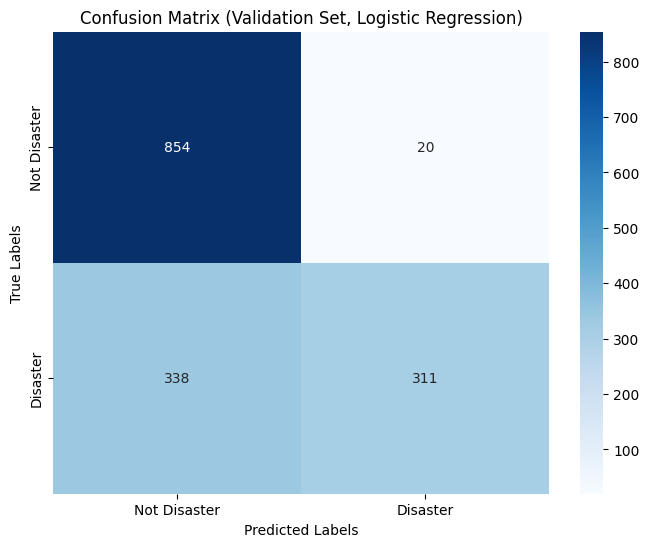

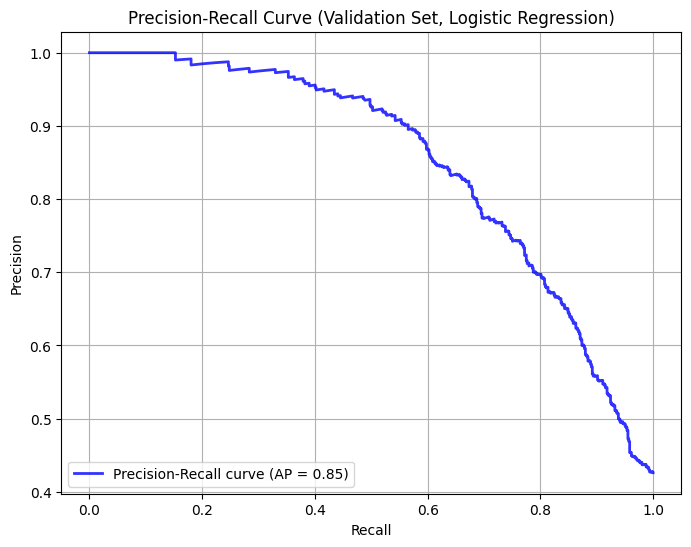

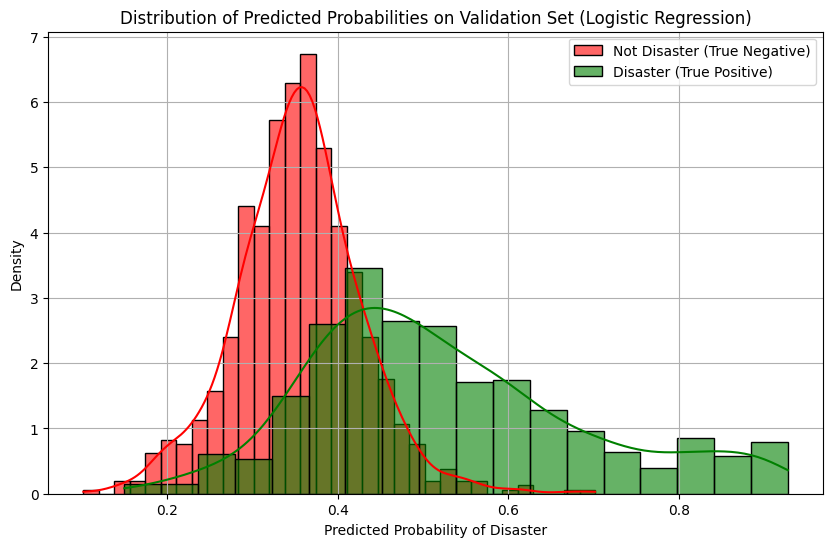


--- Ejemplos de Falsos Positivos (Logistic Regression) ---
Tweet Original: Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE
Tweet Limpio: bringing tornado flood bringing climate change god america plaguing farrakhan quote
--------------------------------------------------
Tweet Original: she's a suicide bomb
Tweet Limpio: shes suicide bomb
--------------------------------------------------
Tweet Original: Over half of poll respondents worry nuclear disaster fading from public consciousness http://t.co/YtnnnD631z ##fukushima
Tweet Limpio: half poll respondent worry nuclear disaster fading public consciousness fukushima
--------------------------------------------------
Tweet Original: dogs Lightning reshapes rocks at the atomic level - A lightning strike can reshape a mineral's crystal structure ... http://t.co/2Wvmij5SA4
Tweet Limpio: dog lightning reshapes rock atomic level lightning strike resha

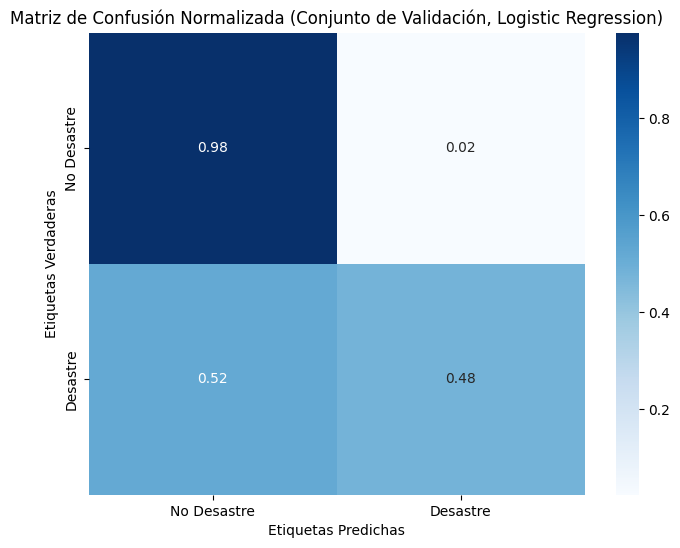

In [ ]:

# 1. Logistic Regression
print("\n--- Modelo: Logistic Regression ---")
X = vectorizer.fit_transform(train_df['text_cleaned'])
y = train_df['target']
X_test = vectorizer.transform(test_df['text_cleaned'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
print(classification_report(y_val, y_pred_val))
y_pred_test = model.predict(X_test)

crear_archivo(pd,"regresion_logistica", y_pred_test)

f1 = f1_score(y_val, y_pred_val)
print(f'F1 SCORE: {f1}')

train_accuracy = accuracy_score(y_train, model.predict(X_train))
val_accuracy = accuracy_score(y_val, y_pred_val)

graficar_resultados(train_accuracy, val_accuracy, y_val, y_pred_val, "Logistic Regression")

model_comparison_metrics['Logistic Regression'] = {'accuracy': val_accuracy, 'f1_score': f1}



--- Modelo: Support Vector Machine (SVM) ---
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       874
           1       0.93      0.44      0.60       649

    accuracy                           0.75      1523
   macro avg       0.82      0.71      0.71      1523
weighted avg       0.80      0.75      0.72      1523

El archivo de entrega del modelo vector_machine fué creado
F1 SCORE: 0.5974842767295597


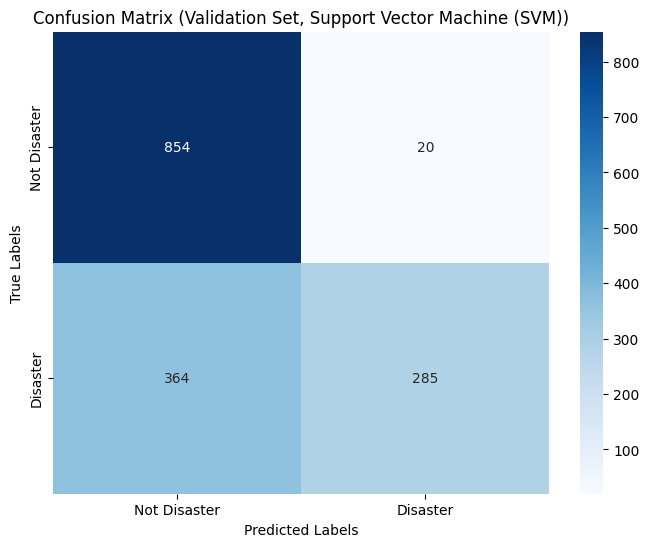

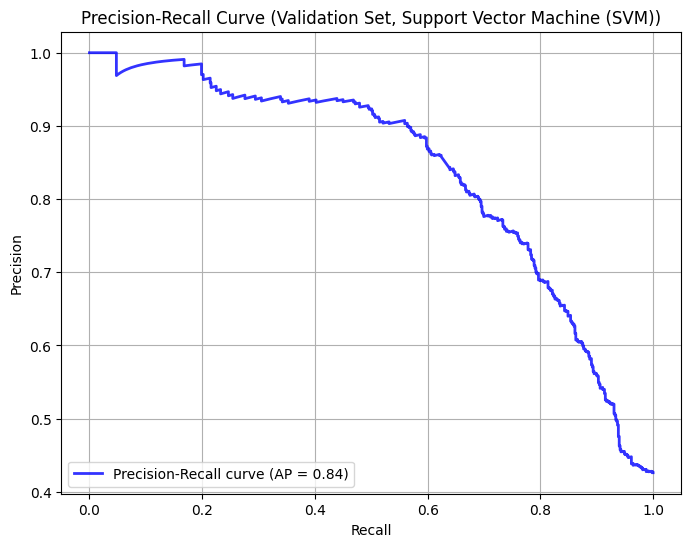

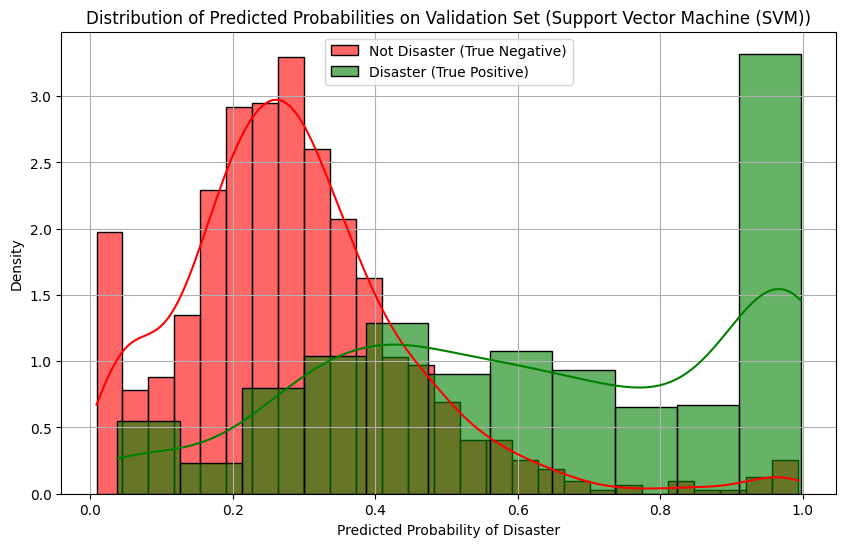


--- Ejemplos de Falsos Positivos (Support Vector Machine (SVM)) ---
Tweet Original: Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE
Tweet Limpio: bringing tornado flood bringing climate change god america plaguing farrakhan quote
--------------------------------------------------
Tweet Original: she's a suicide bomb
Tweet Limpio: shes suicide bomb
--------------------------------------------------
Tweet Original: dogs Lightning reshapes rocks at the atomic level - A lightning strike can reshape a mineral's crystal structure ... http://t.co/2Wvmij5SA4
Tweet Limpio: dog lightning reshapes rock atomic level lightning strike reshape mineral crystal structure
--------------------------------------------------
Tweet Original: @booksbyRoger TY for the follow Go To http://t.co/l9MB2j5pXg BRUTALLY ABUSED+DESOLATE&amp;LOST + HER LOVELY MUM DIES..Is it Murder?
Tweet Limpio: booksbyroger ty follow go brutall

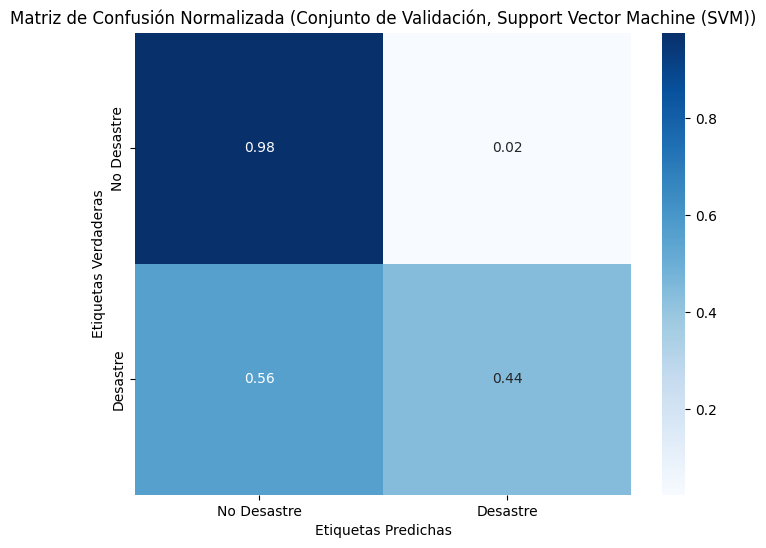

In [ ]:


# 2. Support Vector Machine (SVM)
print("\n--- Modelo: Support Vector Machine (SVM) ---")
X = vectorizer.fit_transform(train_df['text_cleaned'])
y = train_df['target']
X_test = vectorizer.transform(test_df['text_cleaned'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(random_state=42, probability=True) # probability=True para predict_proba en graficar_resultados
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
print(classification_report(y_val, y_pred_val))
y_pred_test = model.predict(X_test)

crear_archivo(pd,"vector_machine", y_pred_test)

f1 = f1_score(y_val, y_pred_val)
print(f'F1 SCORE: {f1}')

train_accuracy = accuracy_score(y_train, model.predict(X_train))
val_accuracy = accuracy_score(y_val, y_pred_val)

graficar_resultados(train_accuracy, val_accuracy, y_val, y_pred_val, "Support Vector Machine (SVM)")

model_comparison_metrics['SVM'] = {'accuracy': val_accuracy, 'f1_score': f1}




--- Modelo: XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:32:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.76      0.89      0.82       874
           1       0.80      0.62      0.70       649

    accuracy                           0.77      1523
   macro avg       0.78      0.75      0.76      1523
weighted avg       0.78      0.77      0.77      1523

El archivo de entrega del modelo XGBoost fué creado
F1 SCORE: 0.6996527777777778


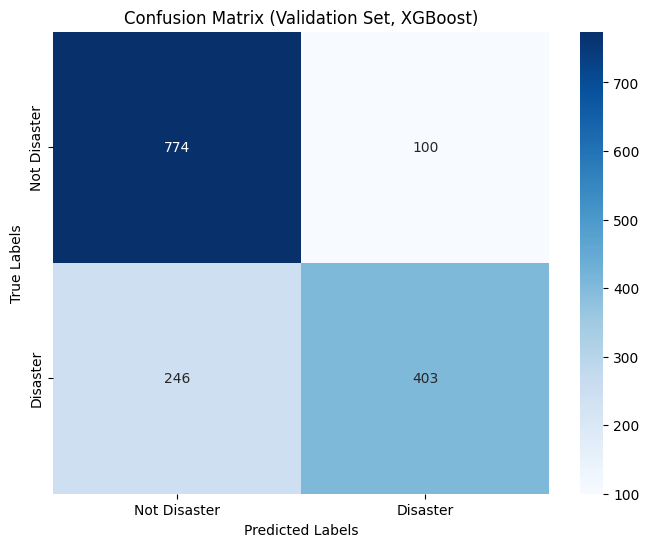

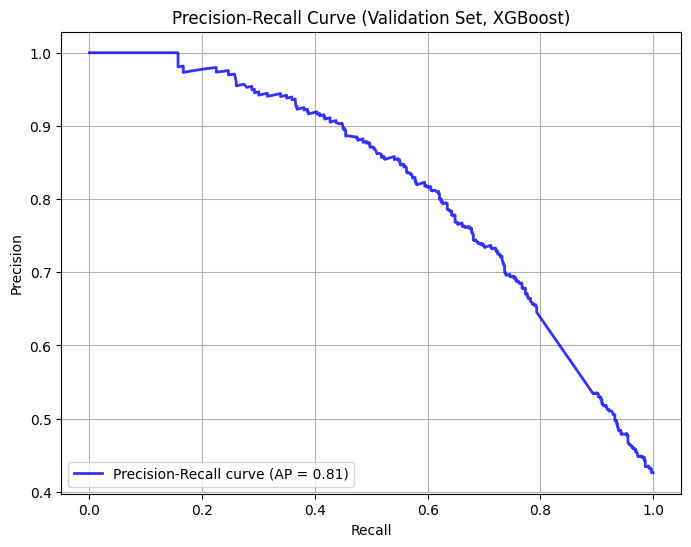

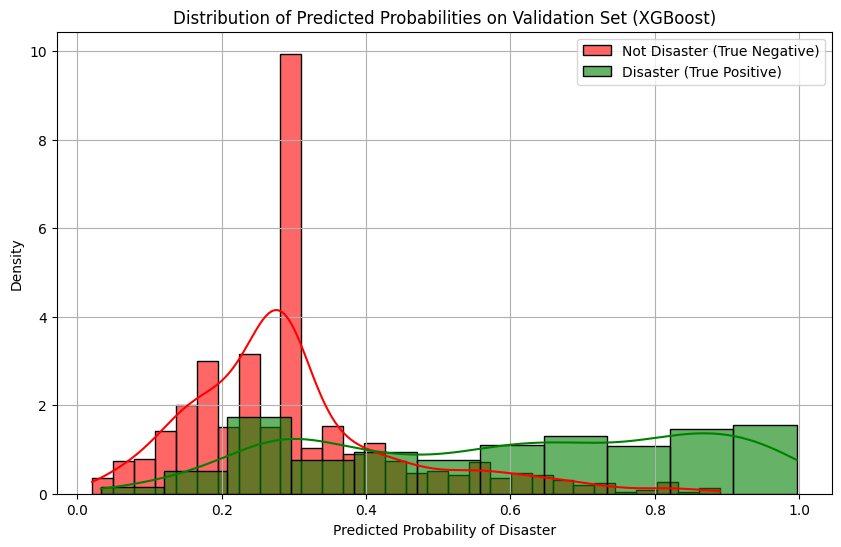


--- Ejemplos de Falsos Positivos (XGBoost) ---
Tweet Original: Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE
Tweet Limpio: bringing tornado flood bringing climate change god america plaguing farrakhan quote
--------------------------------------------------
Tweet Original: @BloopAndABlast Because I need to know if I'm supposed to throw myself off a bridge for a #Collapse or plan the parade. There is no both
Tweet Limpio: bloopandablast need know im supposed throw bridge collapse plan parade
--------------------------------------------------
Tweet Original: she's a suicide bomb
Tweet Limpio: shes suicide bomb
--------------------------------------------------
Tweet Original: Dear @CanonUSAimaging I brought it ;) #CanonBringIt #Fire  #CanonTattoo #MN #TheresMoreWhereThatCameFrom http://t.co/tCXxHdJAs6
Tweet Limpio: dear canonusaimaging brought canonbringit fire canontattoo mn theresmorewherethatc

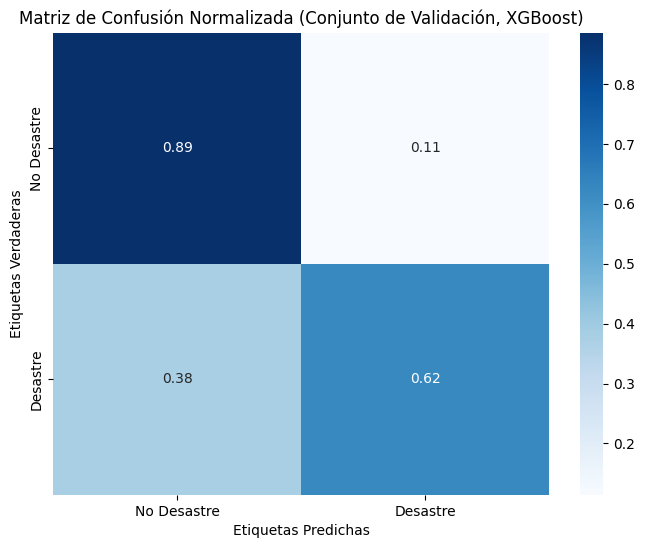

In [ ]:

# 3. XGBoost
print("\n--- Modelo: XGBoost ---")
X = vectorizer.fit_transform(train_df['text_cleaned'])
y = train_df['target']
X_test = vectorizer.transform(test_df['text_cleaned'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
print(classification_report(y_val, y_pred_val))
y_pred_test = model.predict(X_test)

crear_archivo(pd,"XGBoost", y_pred_test)

f1 = f1_score(y_val, y_pred_val)
print(f'F1 SCORE: {f1}')

train_accuracy = accuracy_score(y_train, model.predict(X_train))
val_accuracy = accuracy_score(y_val, y_pred_val)

graficar_resultados(train_accuracy, val_accuracy, y_val, y_pred_val, "XGBoost")

model_comparison_metrics['XGBoost'] = {'accuracy': val_accuracy, 'f1_score': f1}




--- Modelo: Universal Sentence Encoder + Logistic Regression ---

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       869
           1       0.79      0.75      0.77       654

    accuracy                           0.81      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

F1 Score (Validation Set): 0.7697111631537861
Accuracy (Validation Set): 0.8063033486539725


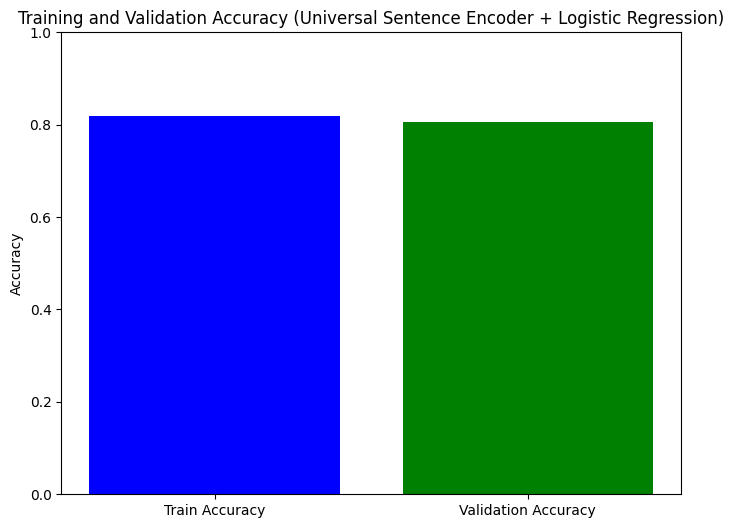

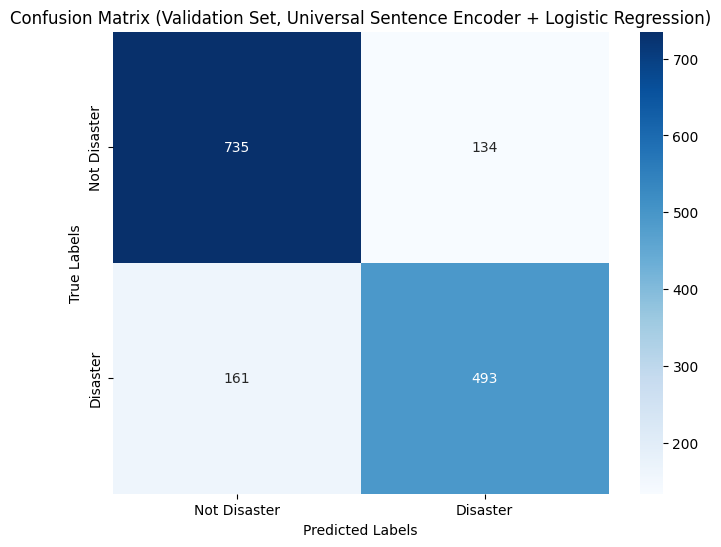

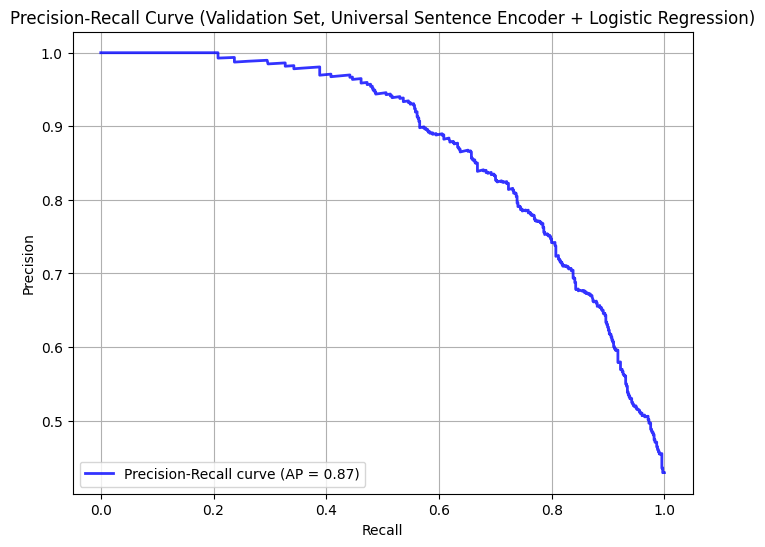

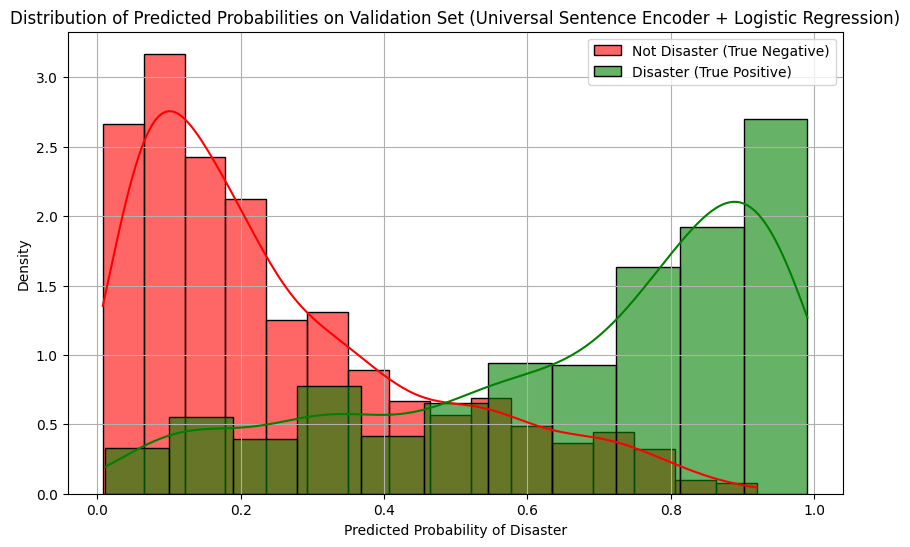

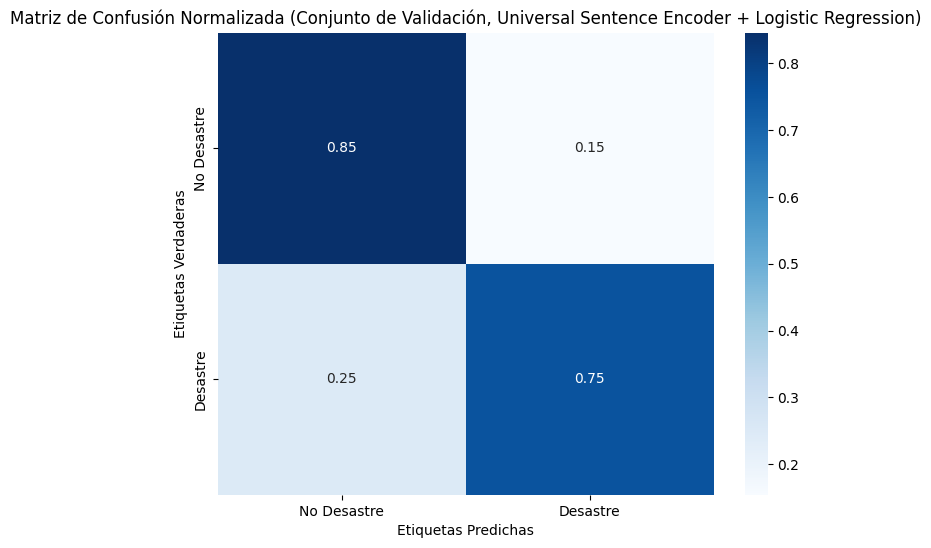

El archivo de entrega del modelo Tensorflow_Universal_Sentence fué creado


In [ ]:

# 4. Tensorflow Universal Sentence Encoder with Logistic Regression
print("\n--- Modelo: Universal Sentence Encoder + Logistic Regression ---")
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
X_train_embeddings = embed(train_df['text_cleaned']).numpy()
X_test_embeddings = embed(test_df['text_cleaned']).numpy()

y_embed = train_df['target'].values # Renombrar para evitar conflicto con 'y' del TfidfVectorizer

X_train_emb, X_val_emb, y_train_emb, y_val_emb = train_test_split(
    X_train_embeddings, y_embed, test_size=0.2, random_state=42, stratify=y_embed # Usar stratify
)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_emb, y_train_emb)

y_pred_val_emb = model.predict(X_val_emb)
print("\nClassification Report (Validation Set):")
print(classification_report(y_val_emb, y_pred_val_emb))
f1_emb = f1_score(y_val_emb, y_pred_val_emb)
print("F1 Score (Validation Set):", f1_emb)
val_accuracy_emb = accuracy_score(y_val_emb, y_pred_val_emb)
print("Accuracy (Validation Set):", val_accuracy_emb)

y_pred_test_emb = model.predict(X_test_embeddings)

train_accuracy_emb = accuracy_score(y_train_emb, model.predict(X_train_emb))

# Necesitamos ajustar graficar_resultados para que use los datos correctos para USE
# Por ahora, pasamos los datos del split de embeddings
# También se necesita val_indices para Falsos Positivos/Negativos. Si no se usa el split original, se pueden omitir esos prints o adaptar.
# Por simplicidad, se adaptará graficar_resultados para USE.
def graficar_resultados_use(train_accuracy, val_accuracy, y_val_data, y_pred_val_data, model_name="", X_val_data=None, model_trained=None, train_df_original=None, val_indices_original=None):
    plt.figure(figsize=(8, 6))
    plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_accuracy, val_accuracy], color=['blue', 'green'])
    plt.ylim(0, 1)
    plt.title(f'Training and Validation Accuracy ({model_name})')
    plt.ylabel('Accuracy')
    plt.show()

    cm = confusion_matrix(y_val_data, y_pred_val_data)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
    plt.title(f'Confusion Matrix (Validation Set, {model_name})')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    if hasattr(model_trained, "predict_proba"):
        y_scores = model_trained.predict_proba(X_val_data)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val_data, y_scores)
        average_precision = average_precision_score(y_val_data, y_scores)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', alpha=0.8, lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve (Validation Set, {model_name})')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.histplot(y_scores[y_val_data == 0], color='red', label='Not Disaster (True Negative)', kde=True, stat='density', alpha=0.6)
        sns.histplot(y_scores[y_val_data == 1], color='green', label='Disaster (True Positive)', kde=True, stat='density', alpha=0.6)
        plt.title(f'Distribution of Predicted Probabilities on Validation Set ({model_name})')
        plt.xlabel('Predicted Probability of Disaster')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()

        if train_df_original is not None and val_indices_original is not None:
            false_positives_local_indices = np.where((y_pred_val_data == 1) & (y_val_data == 0))[0]
            false_negatives_local_indices = np.where((y_pred_val_data == 0) & (y_val_data == 1))[0]

            print(f"\n--- Ejemplos de Falsos Positivos ({model_name}) ---")
            for i_local in false_positives_local_indices[:5]:
                original_df_index = val_indices_original[i_local]
                print(f"Tweet Original: {train_df_original['text'].iloc[original_df_index]}")
                print(f"Tweet Limpio: {train_df_original['text_cleaned'].iloc[original_df_index]}")
                print("-" * 50)

            print(f"\n--- Ejemplos de Falsos Negativos ({model_name}) ---")
            for i_local in false_negatives_local_indices[:5]:
                original_df_index = val_indices_original[i_local]
                print(f"Tweet Original: {train_df_original['text'].iloc[original_df_index]}")
                print(f"Tweet Limpio: {train_df_original['text_cleaned'].iloc[original_df_index]}")
                print("-" * 50)

    cm_normalized = confusion_matrix(y_val_data, y_pred_val_data, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['No Desastre', 'Desastre'], yticklabels=['No Desastre', 'Desastre'])
    plt.title(f'Matriz de Confusión Normalizada (Conjunto de Validación, {model_name})')
    plt.xlabel('Etiquetas Predichas')
    plt.ylabel('Etiquetas Verdaderas')
    plt.show()


# Llamar a la función adaptada para USE
graficar_resultados_use(train_accuracy_emb, val_accuracy_emb, y_val_emb, y_pred_val_emb,
                        "Universal Sentence Encoder + Logistic Regression",
                        X_val_data=X_val_emb, model_trained=model) # No se pasará train_df_original ni val_indices_original aquí para los falsos positivos/negativos ya que el split es sobre los embeddings directamente.

crear_archivo(pd,"Tensorflow_Universal_Sentence", y_pred_test_emb)

model_comparison_metrics['USE + Logistic Regression'] = {'accuracy': val_accuracy_emb, 'f1_score': f1_emb}




--- Modelo: Universal Sentence Encoder + SGDClassifier ---

SGDClassifier - Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       869
           1       0.84      0.68      0.75       654

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523

SGDClassifier - F1 Score (Validation Set): 0.7514843087362172
SGDClassifier - Accuracy (Validation Set): 0.8076165462902167


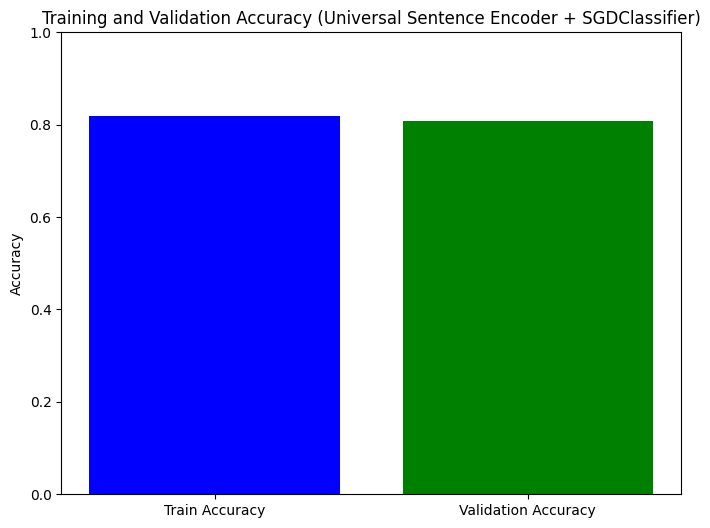

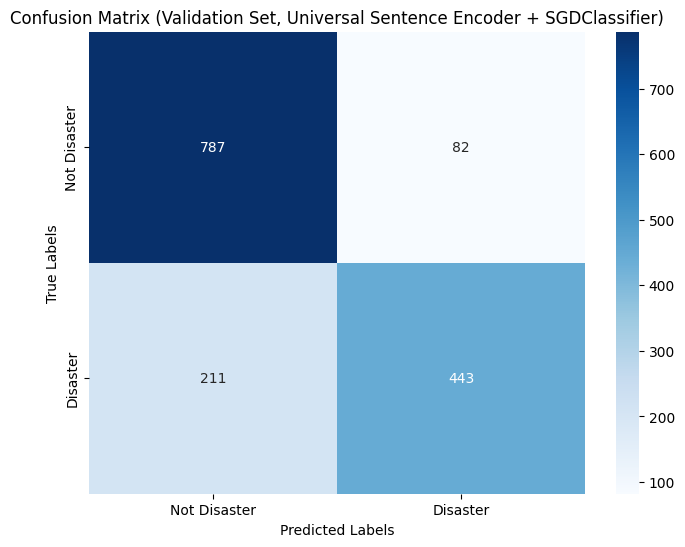

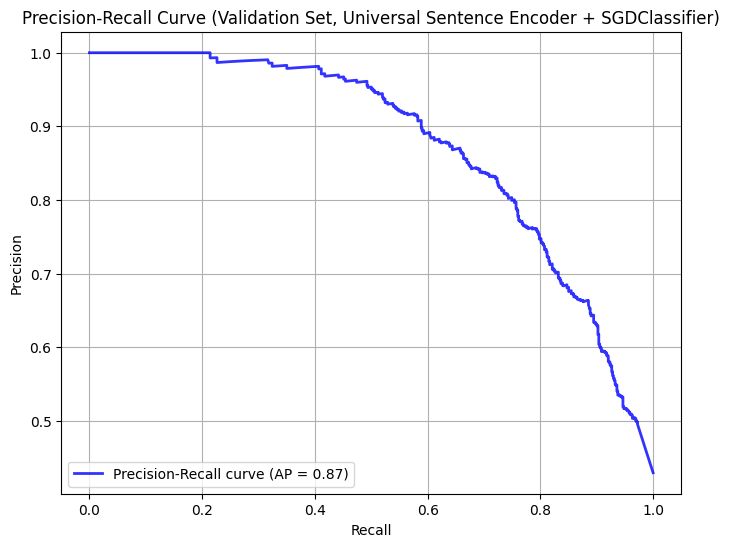

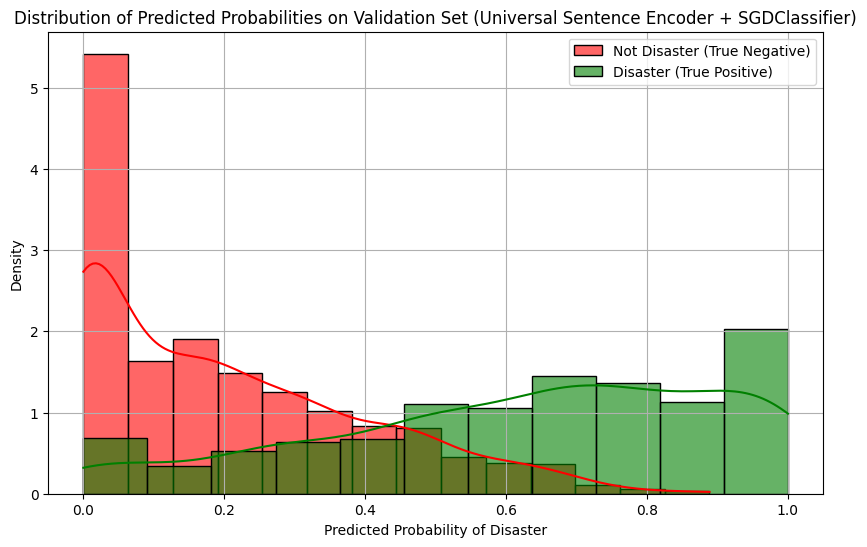

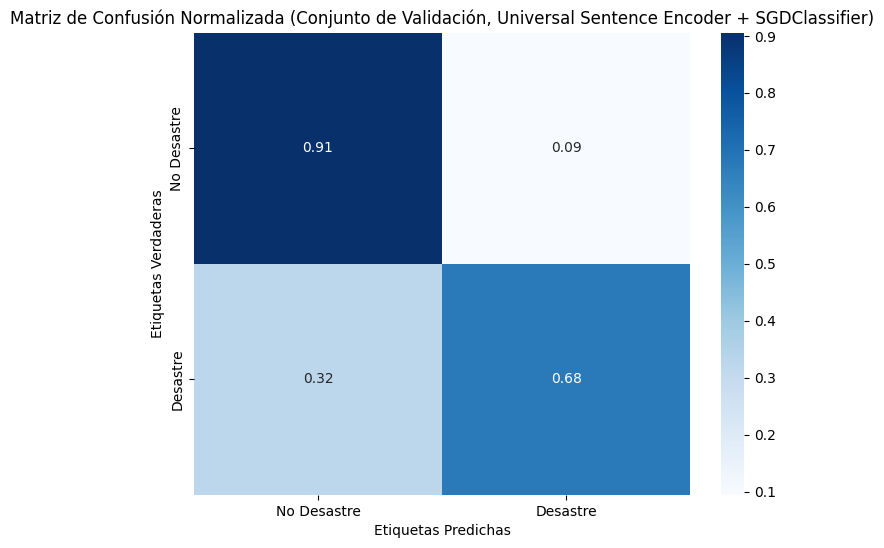

El archivo de entrega del modelo sdg_clasifier fué creado

--- Comparación Global de Modelos ---


<ipython-input-89-86e06f9a99db>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


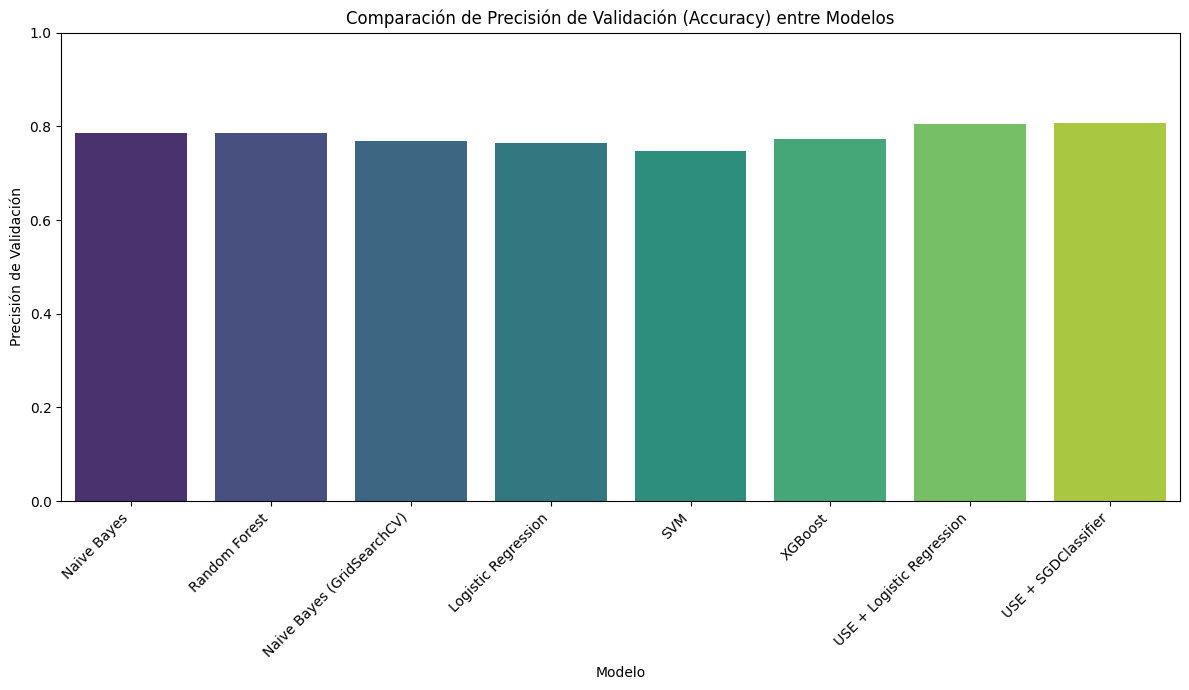

<ipython-input-89-86e06f9a99db>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_scores, palette='magma')


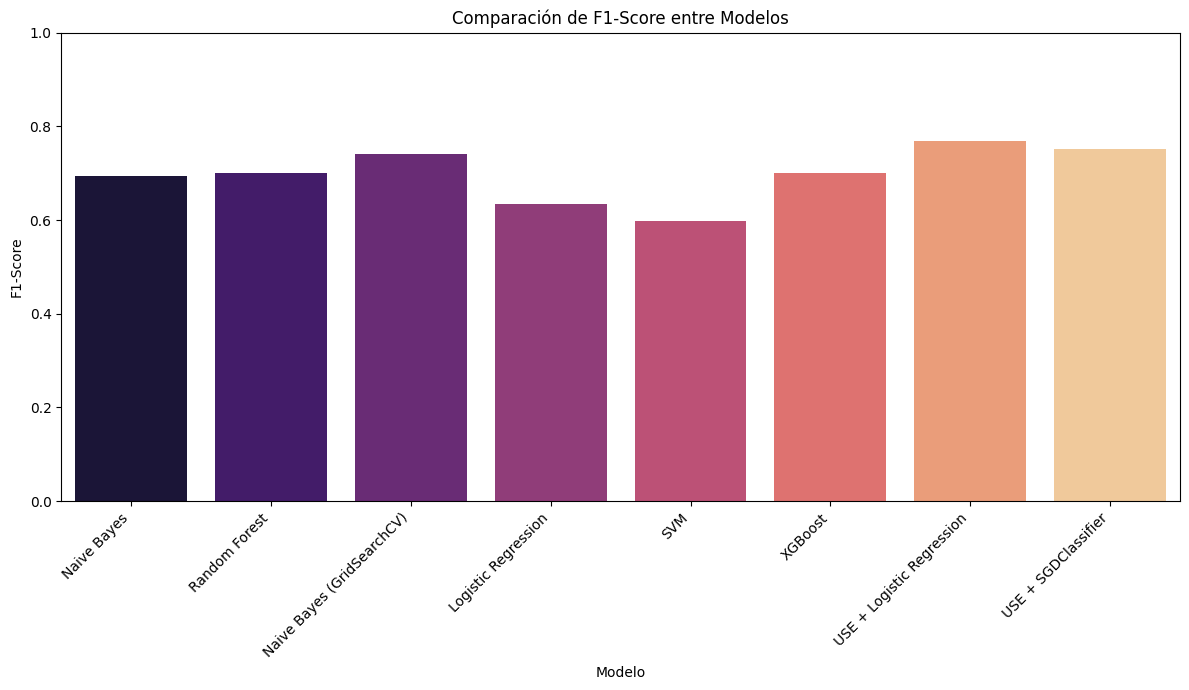


--- Información sobre la Vectorización TF-IDF ---
Forma de la matriz X (entrenamiento): (7613, 143784)
Forma de la matriz X_test (prueba): (3263, 143784)

Representación vectorial del primer tweet (en formato CSR):
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 18 stored elements and shape (1, 143784)>
  Coords	Values
  (0, 31254)	0.2417914612446833
  (0, 101920)	0.17703959416287335
  (0, 37572)	0.1659482330570178
  (0, 79208)	0.14968022095848263
  (0, 2794)	0.20885719176656545
  (0, 48324)	0.2417914612446833
  (0, 31255)	0.2528828223505388
  (0, 101939)	0.2528828223505388
  (0, 37606)	0.2528828223505388
  (0, 79212)	0.23392201530362247
  (0, 2798)	0.2528828223505388
  (0, 31256)	0.2528828223505388
  (0, 101940)	0.2528828223505388
  (0, 37607)	0.2528828223505388
  (0, 79213)	0.2528828223505388
  (0, 31257)	0.2528828223505388
  (0, 101941)	0.2528828223505388
  (0, 37608)	0.2528828223505388

Valores no nulos del primer tweet:
Palabra 'deed': 0.2418
Palabra 'reason': 0.177

In [ ]:

# 5. Tensorflow Universal Sentence Encoder with SGDClassifier
print("\n--- Modelo: Universal Sentence Encoder + SGDClassifier ---")
# Los embeddings ya están generados de la sección anterior
# X_train_embeddings, X_test_embeddings, y_embed

# Split data (asegurarse de usar los embeddings y target correctos para este modelo)
X_train_emb_sgd, X_val_emb_sgd, y_train_emb_sgd, y_val_emb_sgd = train_test_split(
    X_train_embeddings, y_embed, test_size=0.2, random_state=42, stratify=y_embed
)

model_sgd = SGDClassifier(loss="modified_huber", random_state=42, max_iter=1000, tol=1e-3, alpha=0.001, epsilon=0.1)
model_sgd.fit(X_train_emb_sgd, y_train_emb_sgd)

y_pred_val_sgd = model_sgd.predict(X_val_emb_sgd)
print("\nSGDClassifier - Classification Report (Validation Set):")
print(classification_report(y_val_emb_sgd, y_pred_val_sgd))
f1_sgd = f1_score(y_val_emb_sgd, y_pred_val_sgd)
print("SGDClassifier - F1 Score (Validation Set):", f1_sgd)
val_accuracy_sgd = accuracy_score(y_val_emb_sgd, y_pred_val_sgd)
print("SGDClassifier - Accuracy (Validation Set):", val_accuracy_sgd)

y_pred_test_sgd = model_sgd.predict(X_test_embeddings)

train_accuracy_sgd = accuracy_score(y_train_emb_sgd, model_sgd.predict(X_train_emb_sgd))

# Llamar a la función adaptada para USE/embeddings
graficar_resultados_use(train_accuracy_sgd, val_accuracy_sgd, y_val_emb_sgd, y_pred_val_sgd,
                        "Universal Sentence Encoder + SGDClassifier",
                        X_val_data=X_val_emb_sgd, model_trained=model_sgd)


crear_archivo(pd,"sdg_clasifier", y_pred_test_sgd)

model_comparison_metrics['USE + SGDClassifier'] = {'accuracy': val_accuracy_sgd, 'f1_score': f1_sgd}


# --- Finalmente, llamar a la función de comparación de modelos ---
print("\n--- Comparación Global de Modelos ---")
comparar_modelos(model_comparison_metrics)

# Imprimir información sobre la matriz TF-IDF (se mantiene al final)
print("\n--- Información sobre la Vectorización TF-IDF ---")
print("Forma de la matriz X (entrenamiento):", X.shape)
print("Forma de la matriz X_test (prueba):", X_test.shape)
print("\nRepresentación vectorial del primer tweet (en formato CSR):")
print(X[0])

print("\nValores no nulos del primer tweet:")
first_tweet_vector = X[0]
for col_index, value in zip(first_tweet_vector.indices, first_tweet_vector.data):
    feature_name = vectorizer.get_feature_names_out()[col_index]
    print(f"Palabra '{feature_name}': {value:.4f}")